# Анализ базы данных сервиса для чтения книг по подписке

Необходимо проанализировать базу данных, состоящую из пяти таблиц.

- books - данные о книгах
- authors - данные об авторах
- publishers - данные об издательствах
- ratings - данные о пользовательских оценках книг
- reviews - данные о пользовательских обзорах

Познакомимся с ними

In [1]:
# импортируембиблиотеки
import pandas as pd 
from sqlalchemy import create_engine

# устанавливаем параметры
db_config = {'user': 'praktikum_student', # имяпользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432,# портподключения
             'db': 'data-analyst-final-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                         db_config['pwd'],
                                                         db_config['host'],
                                                         db_config['port'],
                                                         db_config['db'])
# сохраняемконнектор
engine = create_engine(connection_string, connect_args={'sslmode':'require'}) 

In [2]:
query = '''select * from books'''
books = pd.io.sql.read_sql(query, con = engine)
books.head(1)

,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93


<div class="alert alert-block alert-info">
    
- _book_id_ — идентификатор книги;
- _author_id_ — идентификатор автора;
- _title_ — название книги;
- _num_pages_ — количество страниц;
- _publication_date_ — дата публикации книги;
- _publisher_id_ — идентификатор издателя.
</div>

In [3]:
query = '''select * from authors'''
authors = pd.io.sql.read_sql(query, con = engine)
authors.head(1)

,author_id,author
0,1,A.S. Byatt


<div class="alert alert-block alert-info">
    
- _author_id_ — идентификатор автора;
- _author_ — имя автора.
</div>

In [4]:
query = '''select * from publishers'''
publishers = pd.io.sql.read_sql(query, con = engine)
publishers.head(1)

,publisher_id,publisher
0,1,Ace


<div class="alert alert-block alert-info">
    
- _publisher_id_ — идентификатор издательства;
- _publisher_ — название издательства;
</div>

In [5]:
query = '''select * from ratings'''
ratings = pd.io.sql.read_sql(query, con = engine)
ratings.head(1)

,rating_id,book_id,username,rating
0,1,1,ryanfranco,4


<div class="alert alert-block alert-info">

- _rating_id_ — идентификатор оценки;
- _book_id_ — идентификатор книги;
- _username_ — имя пользователя, оставившего оценку;
- _rating_ — оценка книги.
    </div>

In [6]:
query = '''select * from reviews'''
reviews = pd.io.sql.read_sql(query, con = engine)
reviews.head(1)

,review_id,book_id,username,text
0,1,1,brandtandrea,Mention society tell send professor analysis. ...


<div class="alert alert-block alert-info">
    
- _review_id_ — идентификатор обзора;
- _book_id_ — идентификатор книги;
- _username_ — имя пользователя, написавшего обзор;
- _text_ — текст обзора.
</div>

## Схема БД

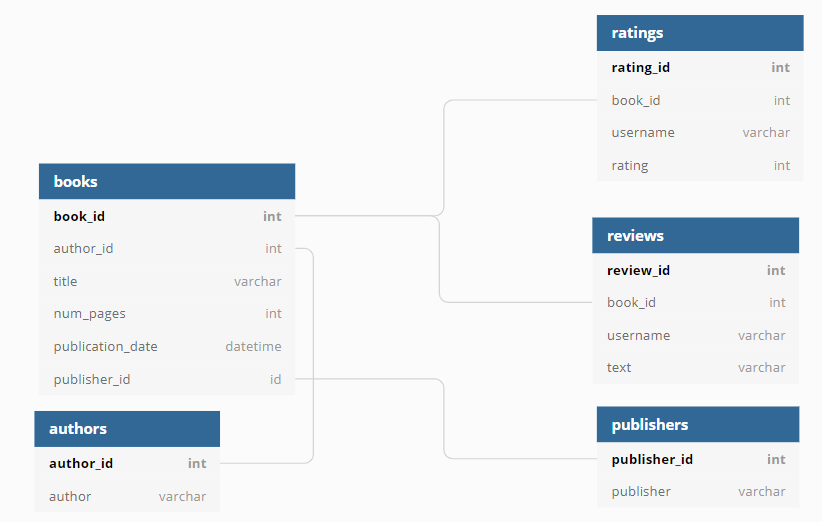

#### Посчитать  сколько книг вышло после 1 января 2000 года

In [7]:
query = ''' select count(book_id) as count_books
                 from books
                 where publication_date > '2000-01-01' '''
count_books = pd.io.sql.read_sql(query, con = engine)
count_books

,count_books
0,819


#### Для каждой книги посчитать количество обзоров и среднюю оценку

In [8]:
query =  ''' select
                subq.book_id,
                subq.count_reviews,
                subq.avg_rating
            from
                ((select
                book_id,
                count(username) as count_reviews
            from
                reviews
            group by
                book_id) as subq1
         inner join       
            (select
                book_id as book,
                avg(rating) as avg_rating
            from
                ratings
            group by
                book) as subq2 on subq1.book_id = subq2.book) as subq
            order by
                count_reviews desc
            '''
reviews_rating = pd.io.sql.read_sql(query, con = engine)
reviews_rating.head()

,book_id,count_reviews,avg_rating
0,948,7,3.662500
1,656,6,4.264151
2,497,6,4.125000
3,963,6,3.977273
4,696,6,3.830508


#### Определите издательство, которое выпустило наибольшее число книг толще 50 страниц — так вы исключите из анализа брошюры

In [9]:
query =  '''select 
                publisher
            from    
                publishers
            inner join    
                 (select
                    publisher_id :: int as publisher_id,
                    count(book_id) as count_book
                from
                    books 
                where
                    num_pages > 50
                group by
                    publisher_id
                order by
                    count_book DESC
                limit
                    1) as subq on publishers.publisher_id = subq.publisher_id
            '''
publisher = pd.io.sql.read_sql(query, con = engine)
publisher

,publisher
0,Penguin Books


#### Определите 10 авторов с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками

In [12]:
query =  '''select
                author
            from
                authors
            inner join
                (select 
                    books.author_id,
                    avg(subq.avg_rating)
                from
                    books
                inner join
                        (select
                            book_id,
                            avg(rating) as avg_rating,
                            count(rating)
                        from
                            ratings
                        group by
                            book_id
                        having
                            count(rating) >= 50)as subq on books.book_id = subq.book_id
                group by
                    author_id
                order by
                    avg desc
                limit
                    10) as subq1 on authors.author_id = subq1.author_id
            '''
best_author = pd.io.sql.read_sql(query, con = engine)
best_author

,author
0,J.K. Rowling/Mary GrandPré
1,Markus Zusak/Cao Xuân Việt Khương
2,J.R.R. Tolkien
3,Louisa May Alcott
4,Rick Riordan
5,William Golding
6,J.D. Salinger
7,Paulo Coelho/Alan R. Clarke/Özdemir İnce
8,William Shakespeare/Paul Werstine/Barbara A. M...
9,Dan Brown


#### Посчитайте среднее количество обзоров от пользователей, которые поставили больше 50 оценок

In [11]:
query =  '''select
                avg(subq1.count_text)
            from
                (select
                    username,
                    count(text) as count_text
                from
                    reviews
                where
                    username in
                        (select
                            subq.username
                        from
                            (select
                                username,
                                count(rating) as count
                            from
                                ratings
                            group by
                                username
                            having
                                count(rating) > 50) as subq)
                group by
                    username) as subq1
            '''
avg_text_from_best_users = pd.io.sql.read_sql(query, con = engine)
avg_text_from_best_users

,avg
0,24.333333
